# Implementing Simon's Algorithm using Qiskit


Import the required packages

In [ ]:
pip install qiskit

In [ ]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [7]:
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

Consider b to be 101, and now lets start building our circuit layer by layer, starting with the hadamard gate to put the bits in quantum superposition

In [11]:
b = '101'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)
simon_circuit.h(range(n))    
simon_circuit.barrier()

Now lets apply an oracle

In [12]:
simon_circuit += simon_oracle(b)
simon_circuit.barrier()

Add hadamard gate to the input register and measure the result

In [13]:
simon_circuit.h(range(n))

simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c_0: ══════════════════════════════════════════╩══╬══╬═
                                                  ║  ║ 
c_1: ═════════════════════════════════════════════╩══╬═
                                                     ║ 
c_2: ════════════════════════════════════════════════╩═

Simulating our result using a histogram

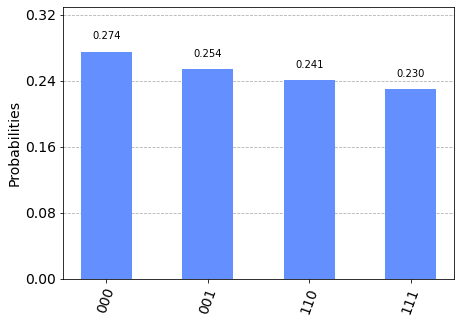

In [14]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simon_circuit, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

Finally lets calculate the dot product of the results

In [15]:
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.001 = 0 (mod 2)
110.111 = 0 (mod 2)
110.000 = 0 (mod 2)
110.110 = 0 (mod 2)


# Generalisation: 


Here we will do similar things done above but now run it on IBM Quantum devices 

In [30]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)
simon_circuit_2.h(range(n))


In [31]:
simon_circuit_2 += simon_oracle(b)
simon_circuit_2.h(range(n))


Measuring QBits

In [32]:
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()

┌───┐                         ┌───┐┌─┐
q_0: ┤ H ├──■─────────■─────────■──┤ H ├┤M├
     ├───┤  │         │  ┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├──┼────■────┼──┤ H ├──┼───┤M├──╫─
     └───┘┌─┴─┐  │  ┌─┴─┐└───┘  │   └╥┘  ║ 
q_2: ─────┤ X ├──┼──┤ X ├───────┼────╫───╫─
          └───┘┌─┴─┐└───┘     ┌─┴─┐  ║   ║ 
q_3: ──────────┤ X ├──────────┤ X ├──╫───╫─
               └───┘          └───┘  ║   ║ 
c_0: ════════════════════════════════╬═══╩═
                                     ║     
c_1: ════════════════════════════════╩═════

Make sure your account is linked with IBMQ

In [22]:
from qiskit import IBMQ
IBMQ.save_account('<your code>')

configrc.store_credentials:WARNING:2020-10-13 17:18:11,972: Credentials already present. Set overwrite=True to overwrite.


In [33]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-10-13 17:39:08,032: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_valencia


Now lets execute and monitor the job

In [34]:
from qiskit.tools.monitor import job_monitor
shots = 1024
job = execute(simon_circuit_2, backend=backend, shots=shots, optimization_level=3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


Now we will get the results and plot counts

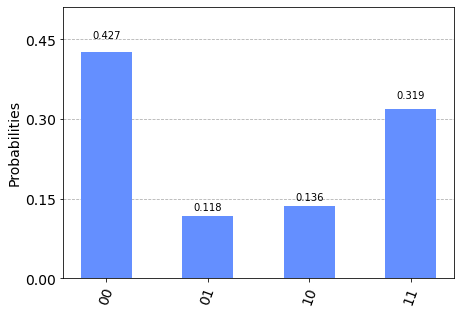

In [35]:
device_counts = job.result().get_counts()
plot_histogram(device_counts)

Finally, calculate the dot product of results

In [36]:
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

b = 11
11.01 = 1 (mod 2) (11.8%)
11.10 = 1 (mod 2) (13.6%)
11.00 = 0 (mod 2) (42.7%)
11.11 = 0 (mod 2) (31.9%)
